In [1]:
import arcpy
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.management import *
from arcpy.conversion import *
from arcpy.da import *
from arcpy.sa import *
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from autogluon.tabular import TabularPredictor,TabularDataset
import shutil

In [2]:
# 分析函数
# 取消并行处理
def disable_parallel_processing(func):
    def wrapper(*args, **kwargs):
        with arcpy.EnvManager(parallelProcessingFactor="0"):
            return func(*args, **kwargs)
    return wrapper
# 采样
def sample_point(point_,raster_,out_name):
    """根据栅格采样点,输出为表格"""
    Sample(raster_,point_,out_name,"NEAREST", "OBJECTID", "CURRENT_SLICE", None, '', None, None, "ROW_WISE", "TABLE")
    return None

# 导出CSV
def export_csv(table_,out_path,out_name):
    TableToTable(table_,out_path,out_name)
    return None
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster
# 数组整形
def resize_arrays(A, B, fill_value=0):
    """调整数组形状一致,A为参考数组, B为待调整数组, fill_value为填充值"""
    # new_shape = (max(A.shape[0], B.shape[0]), max(A.shape[1], B.shape[1]))
    new_shape = (A.shape[0], A.shape[1])

    if A.shape != new_shape:
        if A.shape[0] < new_shape[0]:
            padding_rows = new_shape[0] - A.shape[0]
            padding = np.full((padding_rows, A.shape[1]), fill_value)
            A = np.vstack((A, padding))
        elif A.shape[0] > new_shape[0]:
            A = A[:new_shape[0], :]

        if A.shape[1] < new_shape[1]:
            pad_width = ((0, 0), (0, new_shape[1] - A.shape[1]))
            A = np.pad(A, pad_width, mode='constant', constant_values=fill_value)
        elif A.shape[1] > new_shape[1]:
            A = A[:, :new_shape[1]]
    
    if B.shape != new_shape:
        if B.shape[0] < new_shape[0]:
            padding_rows = new_shape[0] - B.shape[0]
            padding = np.full((padding_rows, B.shape[1]), fill_value)
            B = np.vstack((B, padding))
        elif B.shape[0] > new_shape[0]:
            B = B[:new_shape[0], :]

        if B.shape[1] < new_shape[1]:
            pad_width = ((0, 0), (0, new_shape[1] - B.shape[1]))
            B = np.pad(B, pad_width, mode='constant', constant_values=fill_value)
        elif B.shape[1] > new_shape[1]:
            B = B[:, :new_shape[1]]
    
    return A, B
# rf寻找最优参数
def rf_best_param(X_train,y_train,n_estimators_range,k=5):
    """默认为5折交叉验证,评价指标为R2"""
    # 设置树的数目范围
    n_estimators_range = n_estimators_range
    cv_scores = []
    # 使用交叉验证
    for n_estimators in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
        scores = cross_val_score(rf,X_train, y_train, cv=k, scoring='accuracy')  # K折交叉验证 分类问题默认使用accuracy
        cv_scores.append(scores.mean())
    # 选择最优数量的树
    optimal_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
    return optimal_n_estimators

# arcpy栅格众数滤波
@disable_parallel_processing
def mode_filter(in_raster,filter_size="FOUR",filter_method="MAJORITY"):
    """栅格众数滤波,filter_size:滤波窗口大小,filter_method:滤波方法"""
    result_raster = MajorityFilter(in_raster, filter_size, filter_method) # 默认为4邻域 众数滤波  可选为8邻域 半数滤波
    return result_raster
    
# arcpy栅格边界清理
@disable_parallel_processing
def clean_boundary(in_raster,sort_method="NO_SORT",clean_method="TWO_WAY"):
    """栅格边界清理,sort_method:排序方法,clean_method:清理方法"""
    result_raster = BoundaryClean(in_raster, "NO_SORT", "TWO_WAY") # 默认为不排序 两边清理 可选为排序 一边清理
    return result_raster
# arcpy栅格区域分组
@disable_parallel_processing
def region_group(in_raster,group_size="FOUR",method="WITHIN",add_link="ADD_LINK",clear=None):
    """栅格区域分组,group_size:分组大小,method:分组方法,add_link:添加链接,clear:排除的值"""
    result_raster = RegionGroup(in_raster, group_size, method, add_link, clear) # 默认为4邻域 分组方法为WITHIN 可选为8邻域 分组方法为CROSS
    return result_raster
# arcpy栅格按属性提取
@disable_parallel_processing
def extract_by_attributes(in_raster,where_clause="count >= 100"):
    """栅格按属性提取,where_clause:属性条件"""
    result_raster = ExtractByAttributes(in_raster, where_clause) # 默认为count >= 100
    return result_raster

# arcpy栅格Nibble
@disable_parallel_processing
def nibble(in_raster,mask_raster, nibble_mask="ALL_VALUES", nibble_values="PRESERVE_NODATA"):
    """栅格Nibble,nibble_mask:掩膜,nibble_values:填充值"""
    result_raster = Nibble(in_raster, mask_raster,nibble_mask, nibble_values) # 默认为ALL_VALUES PRESERVE_NODATA 可选为DATA_ONLY PRESERVE_DATA
    return result_raster

# arcpy栅格查找表
@disable_parallel_processing
def lookup(in_raster,lookup_field="LINK"):
    """栅格查找表,lookup_field:查找字段"""
    result_raster = Lookup(in_raster, lookup_field) # 默认为LINK
    return result_raster


In [3]:
# 地理数据库路径
base_gdb_5m = r"D:\ArcgisData\basedata\basetrain_5m.gdb"
base_gdb_30m = r"D:\ArcgisData\basedata\basetrain_30m.gdb"
# 数据点文件路径
point_data = r"D:\ArcgisData\pred_tl\pred_database\pred_tl.gdb\黄棕壤"
# 存储采样数据表的文件地理数据库
sample_gdb_path = r"D:\ArcgisData\pred_organic_p_n\feature_table\tableresult_autogluon.gdb"
# 存储采样结果CSV文件的路径
sample_csv = r"D:\ArcgisData\pred_organic_p_n\feature_table\feature_table_result"
# 输出CSV文件的名称
sample_csv_name = "feature_table_result.csv"
# 目标标签
target_label = "土种"
# 随机森林树的范围
n_estimators_range = range(10, 2000, 10)
# rf模型存储路径
modle_save_path = r"D:\ArcgisData\pred_tl\pred_moudle\autogluon_hzr"
# 栅格输出标准化的数据库
stander_raster_gdb = base_gdb_5m
# 标准化待预测数据分割路径
cut_csv_path = r"D:\ArcgisData\pred_tl\pred_table\autogluon\cut_csv"
# 预测完成CSV文件存储路径
pred_csv_path = r"D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv"
# 完整预测数据存储路径
merge_csv_path = r"D:\ArcgisData\pred_tl\pred_table\autogluon\merge_csv"
# 完整预测数据存储名称
merge_csv_name = "merge.csv"
# 栅格输出预测结果数据库
pred_raster_gdb = r"D:\ArcgisData\pred_tl\pred_database\TL_basedata.gdb"
# 栅格输出预测结果栅格名称
pred_raster_name = "TL_HZR"

In [4]:
# 采样点数据名称
sample_name = '黄棕壤'
filed_list = [_.name for _ in arcpy.ListFields(point_data)]
print(filed_list)
elements_yes = ['OBJECTID', '亚类', '土类','土属','土种']
filter_list = [_ for _ in filed_list if _ in elements_yes]
print(filter_list)


['OBJECTID', 'Shape', '亚类', '土属', '土种', '土类']
['OBJECTID', '亚类', '土属', '土种', '土类']


In [5]:
# 指定指标
# 指标列表['TWI5','TPI201','TPI101','TPI11','TPI3','TMP','SOILQS','SLOP','PRE','NIGTH','NDVI','DEM','CUR','ASP','PLCUR','POCUR','OSJL','LAT','LON','DZ','DL','SOM','SC','PH']
feature_list = ['LAT','LON','DZ','DL','PH','SOM','SC2']


In [10]:
# 使用训练点数据集采样并输出到csv文件
# 选择用于采样的数据库
env.workspace = stander_raster_gdb # 切换工作空间用于采样
# 选择用于采样的要素类
point_data = point_data
# 使用Delete_management函数删除数据库中的所有内容
try:
    arcpy.Delete_management(sample_gdb_path)
except:
    pass
# 再创建一个新的数据库
arcpy.management.CreateFileGDB(os.path.dirname(sample_gdb_path), "tableresult_autogluon", "CURRENT")
# 逐个采样并保存到csv文件
for one_feature in feature_list:
    sample_point(point_data,one_feature,os.path.join(sample_gdb_path,one_feature))
env.workspace = os.path.join(sample_gdb_path) # 切换工作空间用于导出csv文件
# 读取数据表并保存到csv文件
result_df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(point_data,filter_list))
result_df.rename(columns={"OBJECTID":sample_name},inplace=True)
#  读取每个表的最后一个字段的数据,存储每个表的最后一个字段的数据
for table in feature_list:
    # 将表转换为pandas数据帧
    df = pd.DataFrame(arcpy.da.TableToNumPyArray(table, "*"))  # 确保数据表中无空值
    # 提取最后一个字段的数据
    merged_df = df[[sample_name, df.columns[-1]]]
    # 合并
    result_df = pd.merge(result_df, merged_df, on=[sample_name])
# 保存到csv文件
result_df.rename(columns=dict(zip(result_df.columns[-len(feature_list):], feature_list)),inplace=True)
result_df.drop(result_df.columns[0],axis=1,inplace=True)
result_df.to_csv(os.path.join(sample_csv,sample_csv_name),index=False)

In [6]:
# 读取CSV文件使用autogluon训练模型
data = pd.read_csv(os.path.join(sample_csv,sample_csv_name))
data = data[feature_list+[target_label]]
# 列类型转换
data['DL'] = data['DL'].astype('category')
data['DZ'] = data['DZ'].astype('category')
data['SC2'] = data['SC2'].astype('category')
# 划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=0)
# 使用autogluon训练模型
predictor = TabularPredictor(label=target_label,path=modle_save_path,eval_metric='accuracy')
# predictor.fit(train_data=train_data,time_limit=300,presets='good_quality')
predictor.fit(train_data=train_data,time_limit=300,presets='good_quality')

Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "D:\ArcgisData\pred_tl\pred_moudle\autogluon_hzr\"
AutoGluon Version:  0.8.2
Python Version:     3.9.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   478.78 GB / 808.56 GB (59.2%)
Train Data Rows:    272
Train Data Columns: 7
Label Column: 土种
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	9 unique label values:  ['薄层灰泥质黄棕壤', '中层灰泥质黄棕壤', '薄层泥质黄棕壤', '中层泥质黄棕壤', '高泥质黄棕壤', '厚层泥质黄棕壤性土', '薄层泥质黄棕壤性土', '中泥质黄棕壤', '中层泥质黄棕壤性土']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes 

In [7]:

# 加载模型
predictor = TabularPredictor.load(modle_save_path)
# 输出模型再测试集上的准确率,F1值,召回率,精确率
print(accuracy_score(train_data[target_label], predictor.predict(train_data.drop(columns=[target_label]))))
print(accuracy_score(test_data[target_label], predictor.predict(test_data.drop(columns=[target_label]))))
predictor.fit_summary()

0.9375
0.8376068376068376
*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L2   0.906716       0.460207   29.604789                0.000000           0.106508            2      False         12
1         NeuralNetFastAI_BAG_L1   0.902985       0.293559   23.344774                0.293559          23.344774            1      False          1
2           LightGBMLarge_BAG_L1   0.891791       0.098925   10.860764                0.098925          10.860764            1      False         11
3                 XGBoost_BAG_L1   0.891791       0.166649    6.153508                0.166649           6.153508            1      False          9
4          ExtraTreesEntr_BAG_L1   0.888060       0.042002    0.323652                0.042002           0.323652            1       True          8
5          ExtraTr

d:\Program Files\ArcGIS\clone_env\arcgispro-py3\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'NeuralNetFastAI_BAG_L1_FULL': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'CatBoo

In [16]:
# 试验区域预测数据统一
env.workspace = stander_raster_gdb
# 查看数据形状的一致性
stand_shape = arcpy.RasterToNumPyArray(feature_list[0]).shape
err_list = []
for one_raster in feature_list[1:]:
    if arcpy.RasterToNumPyArray(one_raster).shape != stand_shape:
        # 将形状不同的数据输出
        print(one_raster)
        # 重新设置数据形状
        err_list.append(one_raster)
# 构造数据
feature_array_list = []
for one_raster in feature_list:
    if one_raster in err_list:
        # 跳过形状不同的数据
        one_array=resize_arrays(arcpy.RasterToNumPyArray(feature_list[0]),arcpy.RasterToNumPyArray(one_raster), 0)[1]
    else:
        # 读取数据
        one_array = arcpy.RasterToNumPyArray(one_raster)
    # 将数据转换为一维数组
    one_array = one_array.flatten()
    # 将数据添加到列表中
    feature_array_list.append(one_array)
# 将列表转换为数组
feature_array_list = np.column_stack(feature_array_list)

DZ
SOM


In [17]:
# 将数组转换为数据帧
feature_df = pd.DataFrame(feature_array_list,columns=feature_list)
# 修改部分列的数据类型
feature_df['DL'] = feature_df['DL'].astype('category')
feature_df['DZ'] = feature_df['DZ'].astype('category')
feature_df['SC2'] = feature_df['SC2'].astype('category')

In [18]:
# 分割数据并保存为csv文件
#清空文件夹内的所有文件
shutil.rmtree(cut_csv_path)
# 创建文件夹
os.mkdir(cut_csv_path)
chunk_size = 500000  # 每个文件的行数
total_rows = feature_df.shape[0]
for i in range(0, total_rows, chunk_size):
    start = i
    end = min(i + chunk_size, total_rows)
    filename =  os.path.join(cut_csv_path,f'data_chunk_{i}.csv') # 文件名格式可以根据您的需要进行修改
    df_chunk = feature_df.iloc[start:end]
    df_chunk.to_csv(filename, index=False)
    print(i,end=',')

0,500000,1000000,1500000,2000000,2500000,3000000,3500000,4000000,4500000,5000000,5500000,6000000,6500000,7000000,7500000,8000000,8500000,9000000,9500000,10000000,10500000,11000000,11500000,12000000,12500000,13000000,13500000,14000000,14500000,15000000,15500000,16000000,16500000,17000000,17500000,18000000,18500000,19000000,19500000,20000000,20500000,21000000,21500000,22000000,22500000,23000000,23500000,24000000,24500000,25000000,25500000,26000000,26500000,27000000,27500000,28000000,28500000,29000000,29500000,30000000,30500000,31000000,31500000,32000000,32500000,33000000,33500000,34000000,34500000,35000000,35500000,36000000,36500000,37000000,37500000,38000000,38500000,39000000,39500000,40000000,40500000,41000000,41500000,42000000,42500000,43000000,43500000,44000000,44500000,45000000,45500000,46000000,46500000,47000000,47500000,48000000,48500000,49000000,49500000,50000000,50500000,51000000,51500000,52000000,52500000,53000000,53500000,54000000,54500000,55000000,55500000,56000000,56500000,5

In [19]:
# 读取数据
cut_csv_table_list = [os.path.join(cut_csv_path,_) for _ in os.listdir(cut_csv_path)]
# 排序
sorted_csv_files = sorted(cut_csv_table_list, key=lambda x: int(x.rsplit('_', 1)[-1].split('.')[0]))
sorted_csv_files

['D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_0.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_500000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_1000000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_1500000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_2000000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_2500000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_3000000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_3500000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_4000000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_4500000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_5000000.csv',
 'D:\\ArcgisData\\pred_tl\\pred_table\\autogluon\\cut_csv\\data_chunk_5500000.csv',

In [20]:
# 预测试验区域数据
#清空文件夹内的所有文件
shutil.rmtree(pred_csv_path)
# 创建文件夹
os.mkdir(pred_csv_path)
pre_n = 0  # 记录预测的表索引
for one_table in sorted_csv_files:
    data_df = pd.read_csv(one_table)
    temp_pred = predictor.predict(data_df)
    temp_pred = pd.DataFrame(temp_pred,columns=[target_label])
    temp_pred.to_csv(os.path.join(pred_csv_path,f"{pre_n}.csv"))
    pre_n += 1
    print(pre_n,end=',')

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [21]:
# 读取预测结果
pre_csv_list = [os.path.join(pred_csv_path,_) for _ in os.listdir(pred_csv_path)]
sorted_pre_csv_list = sorted(pre_csv_list,key=lambda x:int(x.rsplit('\\', -1)[-1].split('.')[0]))
# 保存完整的预测结果
pred_df = pd.read_csv(sorted_pre_csv_list[0])
for one_pred in sorted_pre_csv_list[1:]:
    temp_df = pd.read_csv(one_pred)
    pred_df = pd.concat([pred_df,temp_df],axis=0)
    print(one_pred,end=',')
pred_df.to_csv(os.path.join(merge_csv_path,merge_csv_name),index=False)

D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\1.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\2.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\3.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\4.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\5.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\6.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\7.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\8.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\9.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\10.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\11.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\12.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\13.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\14.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\15.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\16.csv,D:\ArcgisData\pred_tl\pred_table\autogluon\pre_csv\17.csv,D:\ArcgisData\pred_tl\p

In [22]:
pred_df.head()

,Unnamed: 0,土种
0,0,中层泥质黄棕壤
1,1,中层泥质黄棕壤
2,2,中层泥质黄棕壤
3,3,中层泥质黄棕壤
4,4,中层泥质黄棕壤


In [24]:
le = LabelEncoder()
pred_df['BM'] = le.fit_transform(pred_df['土种'])


In [25]:
pred_df.head()

,Unnamed: 0,土种,BM
0,0,中层泥质黄棕壤,0
1,1,中层泥质黄棕壤,0
2,2,中层泥质黄棕壤,0
3,3,中层泥质黄棕壤,0
4,4,中层泥质黄棕壤,0


In [26]:
result = pred_df.groupby('BM')['土种'].apply(lambda x: list(x.unique())).to_dict()
result

{0: ['中层泥质黄棕壤'],
 1: ['中层灰泥质黄棕壤'],
 2: ['厚层泥质黄棕壤性土'],
 3: ['薄层泥质黄棕壤'],
 4: ['薄层泥质黄棕壤性土'],
 5: ['薄层灰泥质黄棕壤'],
 6: ['高泥质黄棕壤']}

In [27]:
# 输出预测栅格图
env.workspace = stander_raster_gdb
pred_df['category_encoded'] = pd.factorize(pred_df['BM'])[0]
pred_df['category_encoded'] = pred_df['category_encoded'].astype('float32')
raster_array = np.reshape(pred_df['category_encoded'].values,arcpy.RasterToNumPyArray("DEM").shape)
env.extent = "DEM"  # 指定输出栅格的范围
pred_result_raster = mask_raster(raster_array, "DEM",5)
pred_result_raster.save(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

In [ ]:
# --->>>概化栅格
# 读取栅格 并整型
indoor_raster = Raster(os.path.join(pred_raster_gdb,f"{pred_raster_name}"))
int_raster = Int(indoor_raster)
# 1.众数滤波
raster_majority_filter = mode_filter(int_raster,"FOUR","MAJORITY")

# 2.边界清理
raster_boundary_clean = clean_boundary(raster_majority_filter,"NO_SORT","TWO_WAY")

# 3.区域分组
raster_region_group = region_group(raster_boundary_clean,"FOUR","WITHIN","ADD_LINK",None)

# 4.提取区域边界
raster_region_boundary = extract_by_attributes(raster_region_group,"COUNT > 14 0")

# 5.查找表
raster_lookup = lookup(raster_region_group,"LINK")

# 5.蚕食
raster_nibble = nibble(raster_lookup,raster_region_boundary,"ALL_VALUES","PRESERVE_NODATA")
# 6.区域并保存
Int(raster_nibble).save(os.path.join(pred_raster_gdb,f"{pred_raster_name}_nibble"))

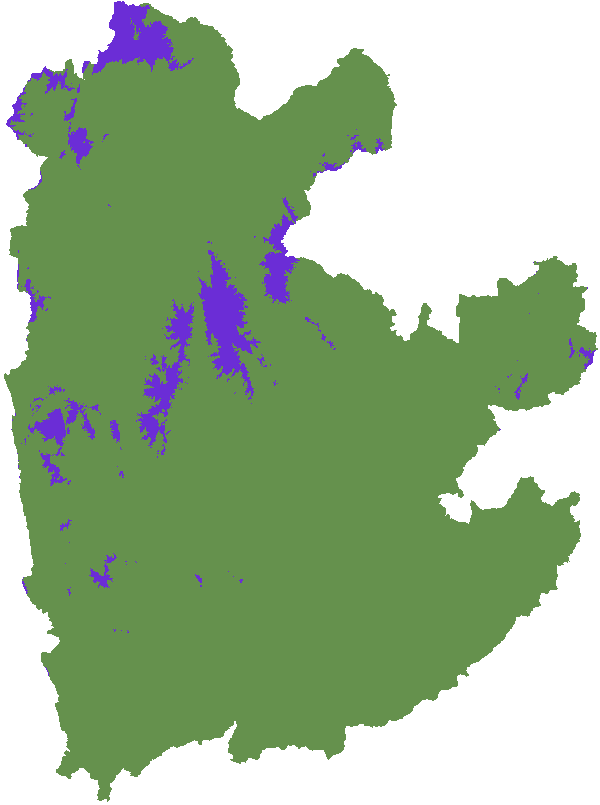

In [76]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

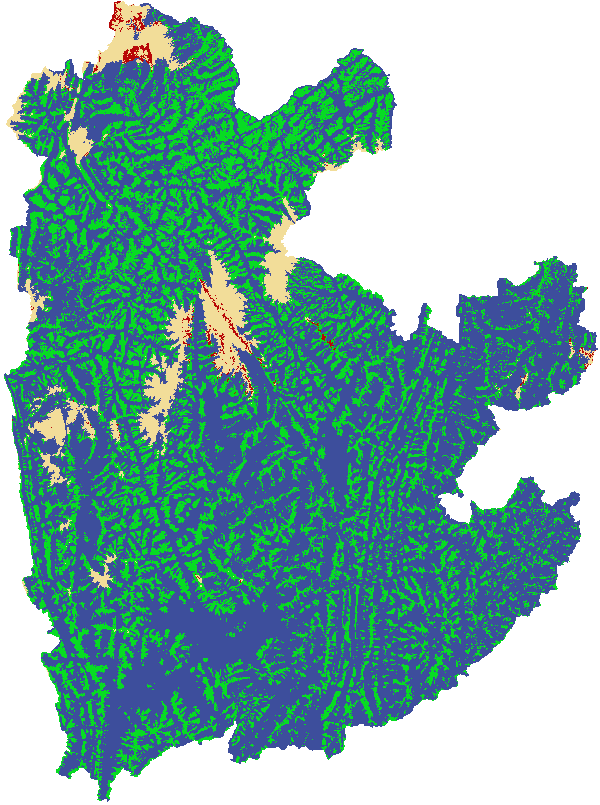

In [89]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

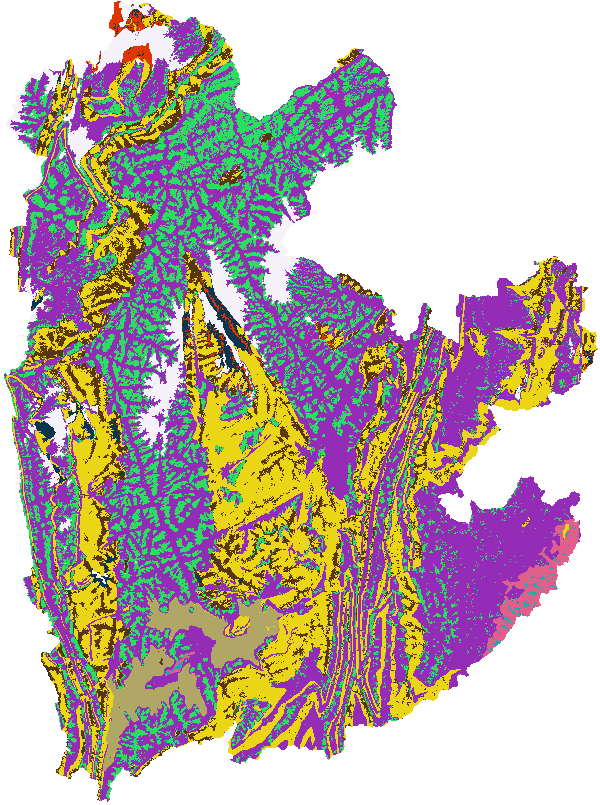

In [101]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

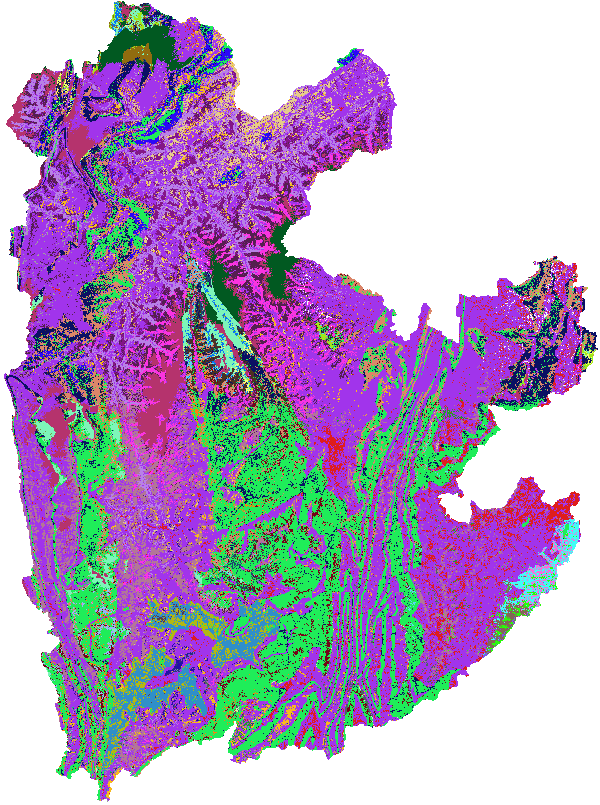

In [128]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

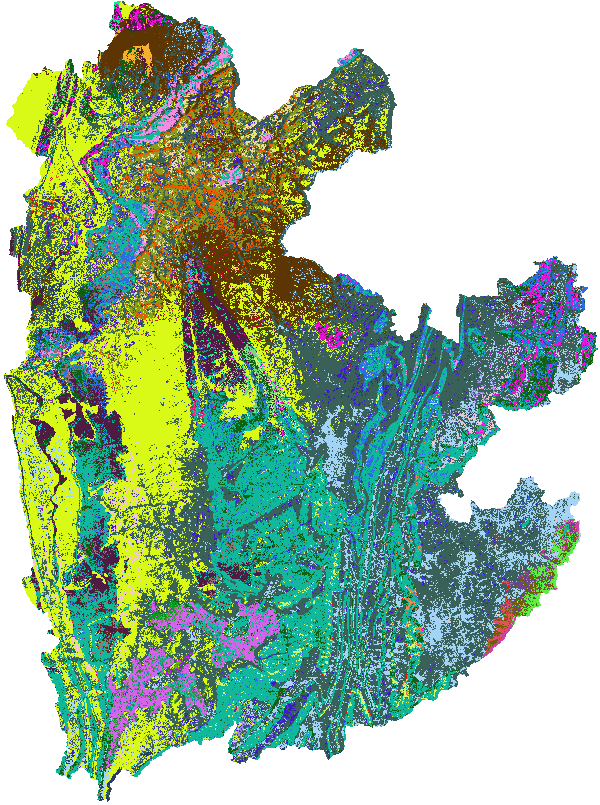

In [16]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred_index"))

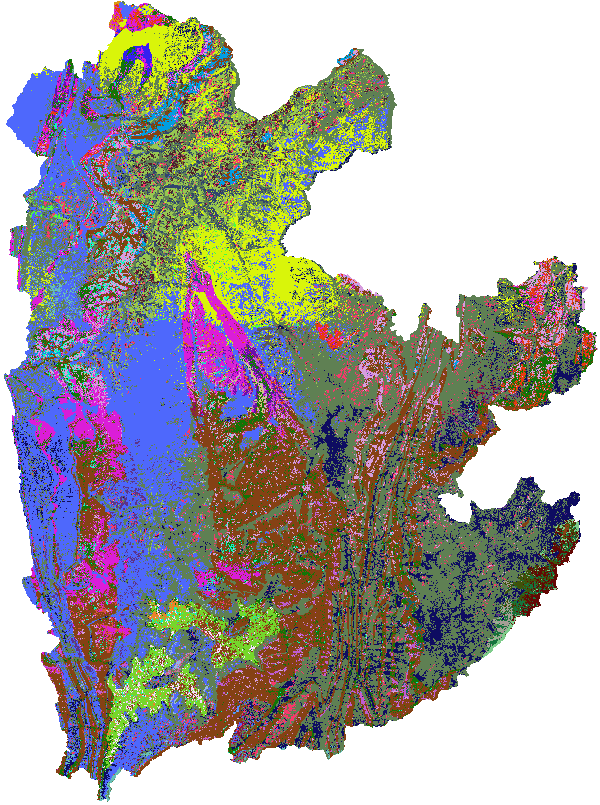

In [16]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred_index_2"))

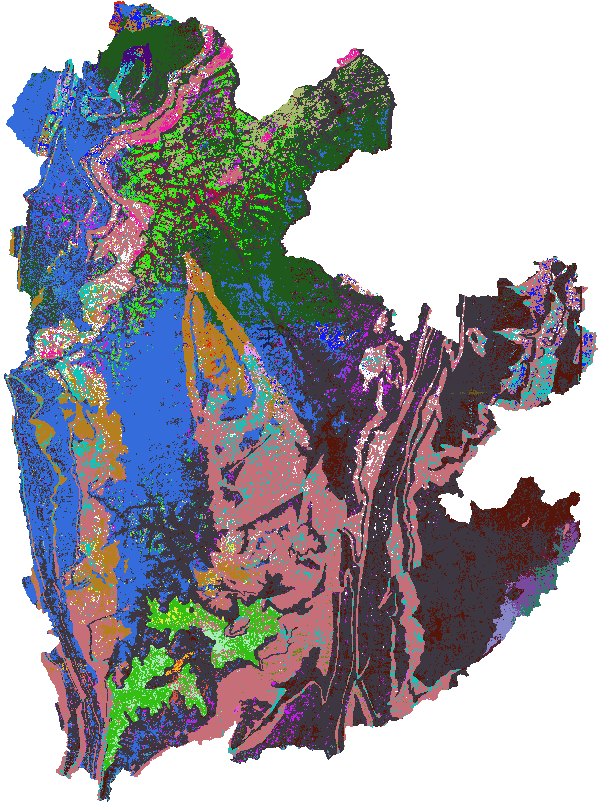

In [40]:
# 预览栅格图
arcpy.sa.Int(os.path.join(pred_raster_gdb,f"{pred_raster_name}_pred"))

In [ ]:
Con((("DL"==2)|("DL"==5)),100+"TL_PRED_FZRT_nibble_200",Con("DL"==1,200+"TL_PRED_SDT_nibble_200",300+"TL_PRED_ZRT_nibble_200"))